# Parallel Iterative Archetypal Analysis Functionalities Demonstration

**author:** Jonathan Yik Chang Ting

**email:** Jonathan.Ting@anu.edu.au

This is a notebook to demonstrate the functionalities provided by *archetypes.py* for the archetypal analysis of given datasets in an iterative manner. The code is developed based on the [code structure and functionalities for visualisation of the *archetypes.py* written by Benyamin Motevalli](https://researchdata.edu.au/archetypal-analysis-package/1424520), who in turn developed his code based on ["Archetypal Analysis" by Adele Cutler and Leo Breiman, Technometrics, November 1994, Vol.36, No.4, pp. 338-347](https://www.jstor.org/stable/1269949).

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

from os import chdir
import pickle
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
import seaborn as sns
import sklearn
from sklearn.datasets import load_diabetes, make_blobs
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# chdir('/scratch/q27/jt5911/iterative-archetypal-analysis')  # Working directory, to be modified by users
import iaa
from iaa import fitPIAA, runAA, subsetSplit, createSimplexAx, mapAlfaToSimplex, plotRadarDatapoint, plotTSNE

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  iaa: {iaa.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  iaa: 0.1.0
  matplotlib: 3.9.0
  numpy: 1.26.4
  pandas: 2.2.2
  scipy: 1.13.1
  seaborn: 0.13.2
  scikit-learn: 1.5.1


In [2]:
# Figure settings
# Variables specific for figures plotting
FIG_SIZE, DPI = (7, 4), 300
CONT_PALETTE, QUAL_PALETTE = 'viridis', 'tab10'
sns.set_style('ticks')
# sns.set_palette(CONT_PALETTE)

SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('legend', title_fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

In [4]:
# General variables
RANDOM_STATE = 42
NUM_DIM_MANIFOLD = 2
VERBOSE = True
NUM_JOBS = 48

# Variables specific for splitting data into subsets
SHUFFLE = True  # Whether to shuffle data samples before splitting.

# Variables specific for archetypes.py functionalities
C = 0.0001  # constraint coefficient to ensure that the summation of alpha and beta equals to 1.

# Variables specific for the archetypal analysis algorithm provided by the SPArse Modeling Software (SPAMS) package
ROBUST = False  # Whether to use modified AA algorithm to deal with outliers
TOLERANCE = 0.001  # Threshold to decide when to stop optimisation.
COMPUTE_XTX = False  # Whether to compute X^T * X
STEPS_FISTA = 3  # Number of steps for fast iterative shrinkage-thresholding algorithm
STEPS_AS = 50  # Number of steps for active set algorithm
RANDOM_INIT = False  # Whether to initialise the archetypes randomly

# Directory paths
SUBSETS_PICKLES_PATH = "./data/subsetsDataPKLs"
OUTPUTS_PICKLES_PATH = "./data/subsetsOutputsPKLs"
FIGS_DIR_PATH = './figs/'
PBS_SCRIPT_DIR = "./jobScripts"

# Set random seed
np.random.seed(RANDOM_STATE)

### Data Visualisation

For the visualisation of the (often high-dimensional) data, *t*-distributed stochastic neighbour embedding (*t*-SNE) is used.

#### Advantages
*t*-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student's *t*-distributions. This allows *t*-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:
- Revealing the structure at many scales on a single map.
- Revealing data that lie in multiple, different, manifolds or clusters.
- Reducing the tendency to crowd points together at the center.

#### Disadvantages
The disadvantages to using *t*-SNE are:
- *t*-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes.
- The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.
- The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.

#### Recommendations
*t*-SNE converts similarities between data points to joint probabilities and minimises the Kullback-Leibler (KL) divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. The KL divergence of the joint probabilities in the original space and the embedded space are minimised by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initialisations will end up in local minima of the KL divergence. Hence, it is useful to try different seeds and select the embedding with the lowest KL divergence.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. 

#### Why not UMAP?
Compared to uniform manifold approximation and projection (UMAP), *t*-SNE provides higher flexibility for the emphasis of local structures. While UMAP was thought to be superior in preserving global data structure, this was recently found to be attributed to the initialisation method (Users are directed to the [publication of Kobak and Linderman in 2021](https://doi.org/10.1038/nbt.4314) for further details). Consequently, *t*-SNE with informative initialisation (such as PCA initialisation) performs as well as UMAP in terms of preservation of global structure.

#### Why not other techniques?

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, *t*-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

#### Essential *t*-SNE Parameters

Parameters controlling the optimisation of *t*-SNE and therefore possibly the quality of the resulting embedding:
- **perplexity**: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value from [5, 50]. Different values can result in significantly different results. The perplexity must be less than the number of samples.
- **early_exaggeration**: Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.
- **learning_rate**: The learning rate for *t*-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help. The 'auto' option sets the learning_rate to $\text{max}(N / \text{early\_exaggeration} / 4, 50)$ where $N$ is the sample size, following the [work of Belkina et al.](https://doi.org/10.1038/s41467-019-13055-y) and the [work of Kobak and Berens](https://doi.org/10.1038/s41467-019-13056-x).
- **n_iter**: Maximum number of iterations for the optimization. Should be at least 250.
- **angle**: Angular size (referred to as theta in the [work of van der Maaten](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf)) of a distant node as measured from a point. If this size is below 'angle' then it is used as a summary node of all points contained within it. This method is not very sensitive to changes in this parameter in the range of [0.2, 0.8]. Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error. Only used if **method**='barnes_hut' This is the trade-off between speed and accuracy for Barnes-Hut *t*-SNE. 

Other Parameters:
- **n_components**: Dimension of the embedded space.
- **min_grad_norm**: If the gradient norm is below this threshold, the optimization will be stopped.
- **metric**: The metric to use when calculating distance between instances in a feature array. The default is “euclidean” which is interpreted as squared euclidean distance.
- **init**: Initialisation of embedding. PCA initialisation cannot be used with precomputed distances and is usually more globally stable than random initialisation.
- **method**: By default the gradient calculation algorithm uses Barnes-Hut approximation running in $O(N\text{log}N)$ time. The 'exact' option will run on the slower, but exact, algorithm in $O(N^2)$ time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

The effects of changing the parameters of *t*-SNE can be understood from [some experiments visualised](https://distill.pub/2016/misread-tsne/)!

## Reference vs Parallel Iterative Archetypal Analysis

We will first use a few two-dimensional datasets to allow visual comparisons between the reference and parallel iterative approaches to archetypal analysis of a given dataset.

### Arguments Description
- **nArchetypes**: Defines how many archetypes will be extracted. A positive integer. Setting to 1 return the mean of the data set. *Default = 2*.
- **iterative**: Whether to use the iterative or reference approach. *Default = False*.
- **n_subsets**: The number of subsets to split the data into if **iterative** = True. *Default = 10*.
- **shuffle**: Whether to shuffle the data samples before splitting. *Default = True*.
- **onlyZ**: Whether to stop running when archetypes are computed. Setting to True allows only archetypes and run time to be returned. *Default = False*.
- **C**: the weight on the constraint equation. Inversely proportional to the strength of constraint. *Default = 0.0001*. Constraint Equation: $$\sum\alpha = 1,$$ $$\sum\beta = 1$$

The following arguments are specific to the archetypal analysis algorithm provided by the [SPArse Modeling Software (SPAMS) package](https://thoth.inrialpes.fr/people/mairal/spams/), hence Users are directed to their homepage and the original publication describing the algorithm in "[Fast and Robust Archetypal Analysis for Representation Learning](https://ieeexplore.ieee.org/document/6909588)" for up-to-date and detailed descriptions.
- **robust**
- **tolerance**
- **computeXtX**
- **stepsFISTA**
- **stepsAS**
- **randominit**
- **random_state**
- **numThreads**

### General Functions

In [5]:
def plotFirst2D(X, figName='', figSize=(3, 3), markerSize=1, numComponents=2, markIdxs=[]):
    plt.figure(figsize=figSize)
    plt.scatter(X[:, 0], X[:, 1], s=markerSize, c='k') # c=range(len(X)), cmap=CONT_PALETTE)
    plt.scatter(x=X[markIdxs, 0], y=X[markIdxs, 1], 
                marker='D', s=markerSize*30, facecolor='r', edgecolor='k', linewidth=0.8)
    plt.grid(linestyle='dotted')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if len(markIdxs) > 0:
        plt.legend(['Sample', 'Most archetypal sample'], bbox_to_anchor=[0.5, -0.35], loc='center')
    plt.savefig(f"{FIGS_DIR_PATH}/{figName}.png", bbox_inches='tight')

In [6]:
def plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=True, figName='',
                  figSize=(7, 4), dpi=300, verbose=False):
    """Plot the data and archetypes from both approaches."""
    Zreference, Ziterative = AAreference.archetypes, AAiterative.archetypes
    # if verbose:
    #     print(f"Archetype set from reference approach:\n{Zreference}")
    #     print(f"Archetype set from iterative approach:\n{Ziterative}")

    sns.set_palette(QUAL_PALETTE)
    plt.figure(figsize=figSize, dpi=dpi)
    if not plotSubsets:
        plt.scatter(Xscaled[:, 0], Xscaled[:, 1], marker='.', s=5) # color='y', 
    else:
        for idxs in AAiterative.subsetsSampleIdxs: 
            plt.scatter(Xscaled[idxs, 0], Xscaled[idxs, 1], marker='.', s=5)
    allSubsetsZs =  np.concatenate(AAiterative.subsetsZs, axis=1)
    plt.plot(Zreference[0, :], Zreference[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='r', alpha=0.5)  # color='m'
    plt.plot(Ziterative[0, :], Ziterative[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='b', alpha=0.5)  # color='c'
    plt.plot(allSubsetsZs[0, :], allSubsetsZs[1, :], 'D', markersize=4, markeredgecolor='k', markeredgewidth=0.6, color='y')  # color='b'
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(linestyle='dotted')
    legendEntries = [f"Data Subset {i+1}" for i in range(len(AAiterative.subsetsSampleIdxs))] if plotSubsets else ['Data']
    legendEntries += [f"Reference Approach Archetypes, ExpVar: {AAreference.explainedVariance_:.3f}", f"Iterative Approach Archetypes, ExpVar: {AAiterative.explainedVariance_:.3f}", 'Archetypes from Split Sets']
    plt.legend(legendEntries, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=False, fontsize='x-small')
    plt.tight_layout()
    plt.savefig(f"{FIGS_DIR_PATH}/{figName}.png")

In [6]:
def runRAA(Xscaled, numArchetypes=4, robust=False, onlyZ=False, randomState=42, verbose=False):
    AAreference = ArchetypalAnalysis(nArchetypes=numArchetypes, iterative=False, robust=robust, onlyZ=onlyZ,
                                     C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                     randomState=randomState, numThreads=NUM_JOBS)
    AAreference.fit(Xscaled)
    if verbose:
        print(f"Reference archetypal analysis execution time: {AAreference.runTime:.3f} s")
        print(f"Explained variance: {AAreference.explainedVariance_:.3f}\n")
    return AAreference

In [7]:
def runPIAA1(Xscaled, numArchetypes=4, numSubset=4, shuffle=True, randomState=42, 
             datasetType='uniformSquare', numCPUs=48, wallTime='01:00:00', mem=190, verbose=False):
    splitRunTime = subsetSplit(Xscaled, n_subsets=numSubset, dataName=datasetType, subsetsPicklesPath=SUBSETS_PICKLES_PATH,
                               shuffle=shuffle, randomState=randomState, verbose=verbose)
    # Arguments: (i) dataset name, (ii) number of archetypes, (iii) number of CPUs, (iv) walltime, (v) memory (GB)
    !./runAAs.sh {datasetType} {numArchetypes} {numCPUs} {wallTime} {mem}
    return splitRunTime

In [8]:
def runPIAA2(Xscaled, numArchetypes=4, numSubset=4, onlyZ=False,
             robust=False, shuffle=True, randomState=RANDOM_STATE, 
             datasetType='uniformSquare', verbose=False, splitRunTime=0.0):
    AAiterative = fitPIAA(Xscaled, nArchetypes=numArchetypes, numSubset=numSubset, 
                          dataName=datasetType, outputsPicklesPath=OUTPUTS_PICKLES_PATH, 
                          shuffle=shuffle, robust=robust, onlyZ=onlyZ, C=0.0001, tolerance=TOLERANCE, 
                          computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                          randomState=randomState, numThreads=NUM_JOBS, splitRunTime=splitRunTime, verbose=verbose)
    if verbose:
        print(f"Parallel iterative archetypal analysis {numSubset} subsets execution time: {AAiterative.runTime:.3f} s\n")
    return AAiterative

In [9]:
def runAAonData(Xscaled, AAreference, AAiterative,
                datasetType='uniformSquare', plotSubsets=True, figSize=(7, 4), dpi=300, verbose=False):
    colourSubsetsStr = 'colourSubsets' if plotSubsets else 'colourWholeSet'
    plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=plotSubsets, figName=f"{datasetType}_{numSubset}-fold_{colourSubsetsStr}",
                  figSize=figSize, dpi=dpi, verbose=verbose)

### Uniform Square

#### Load Data

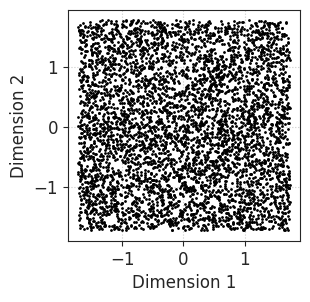

In [10]:
# Generate data
NUM_SAMPLES = 5000
DATASET_TYPE = 'uniformSquarePIAA'
x = np.random.uniform(-10, 10, NUM_SAMPLES)
y = np.random.uniform(-10, 10, NUM_SAMPLES)
X = np.array([[xi, yi] for xi, yi in zip(x, y)])

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Visualise data
plotFirst2D(Xscaled, figName=DATASET_TYPE)  # First two dimensions
plotTSNE(Xscaled, figNamePrefix=DATASET_TYPE, perplexity=100)  # Manifold learning

#### Extracting Archetypes

Here we extract the *4* archetypes from the dataset. For the iterative approach we also compare the results when we split the original dataset into *2* and *8* subsets.

##### 2 Subsets

In [73]:
numArchetypes, numSubset = 4, 2

# Run the reference archetypal analysis for comparison with the parallel iterative approach
AAreference = runRAA(Xscaled, numArchetypes=numArchetypes, robust=ROBUST, onlyZ=False, randomState=RANDOM_STATE, verbose=VERBOSE)

In [76]:
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 2 subsets...
  Subset 1
  Subset 2
Running archetypal analysis for all subsets...
119658542.gadi-pbs
  Submitted job for uniformSquarePIAA2Sdata1.pkl
119658543.gadi-pbs
  Submitted job for uniformSquarePIAA2Sdata2.pkl


In [79]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: uniformSquarePIAA2Soutput1.pkl
  Subset: uniformSquarePIAA2Soutput2.pkl
RSS FISTA = 0.0068938528
RSS FISTA = 0.0036517131
RSS FISTA = 0.0036526515
RSS AS = 0.0025685998
RSS AS = 0.0017760152
RSS AS = 0.0015868492
RSS AS = 0.0015424039
RSS AS = 0.0015320722
RSS AS = 0.0015296742
RSS AS = 0.0015291178
RSS AS = 0.0015290038
RSS AS = 0.0015289936
RSS AS = 0.0015289915
RSS AS = 0.001528991
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS =

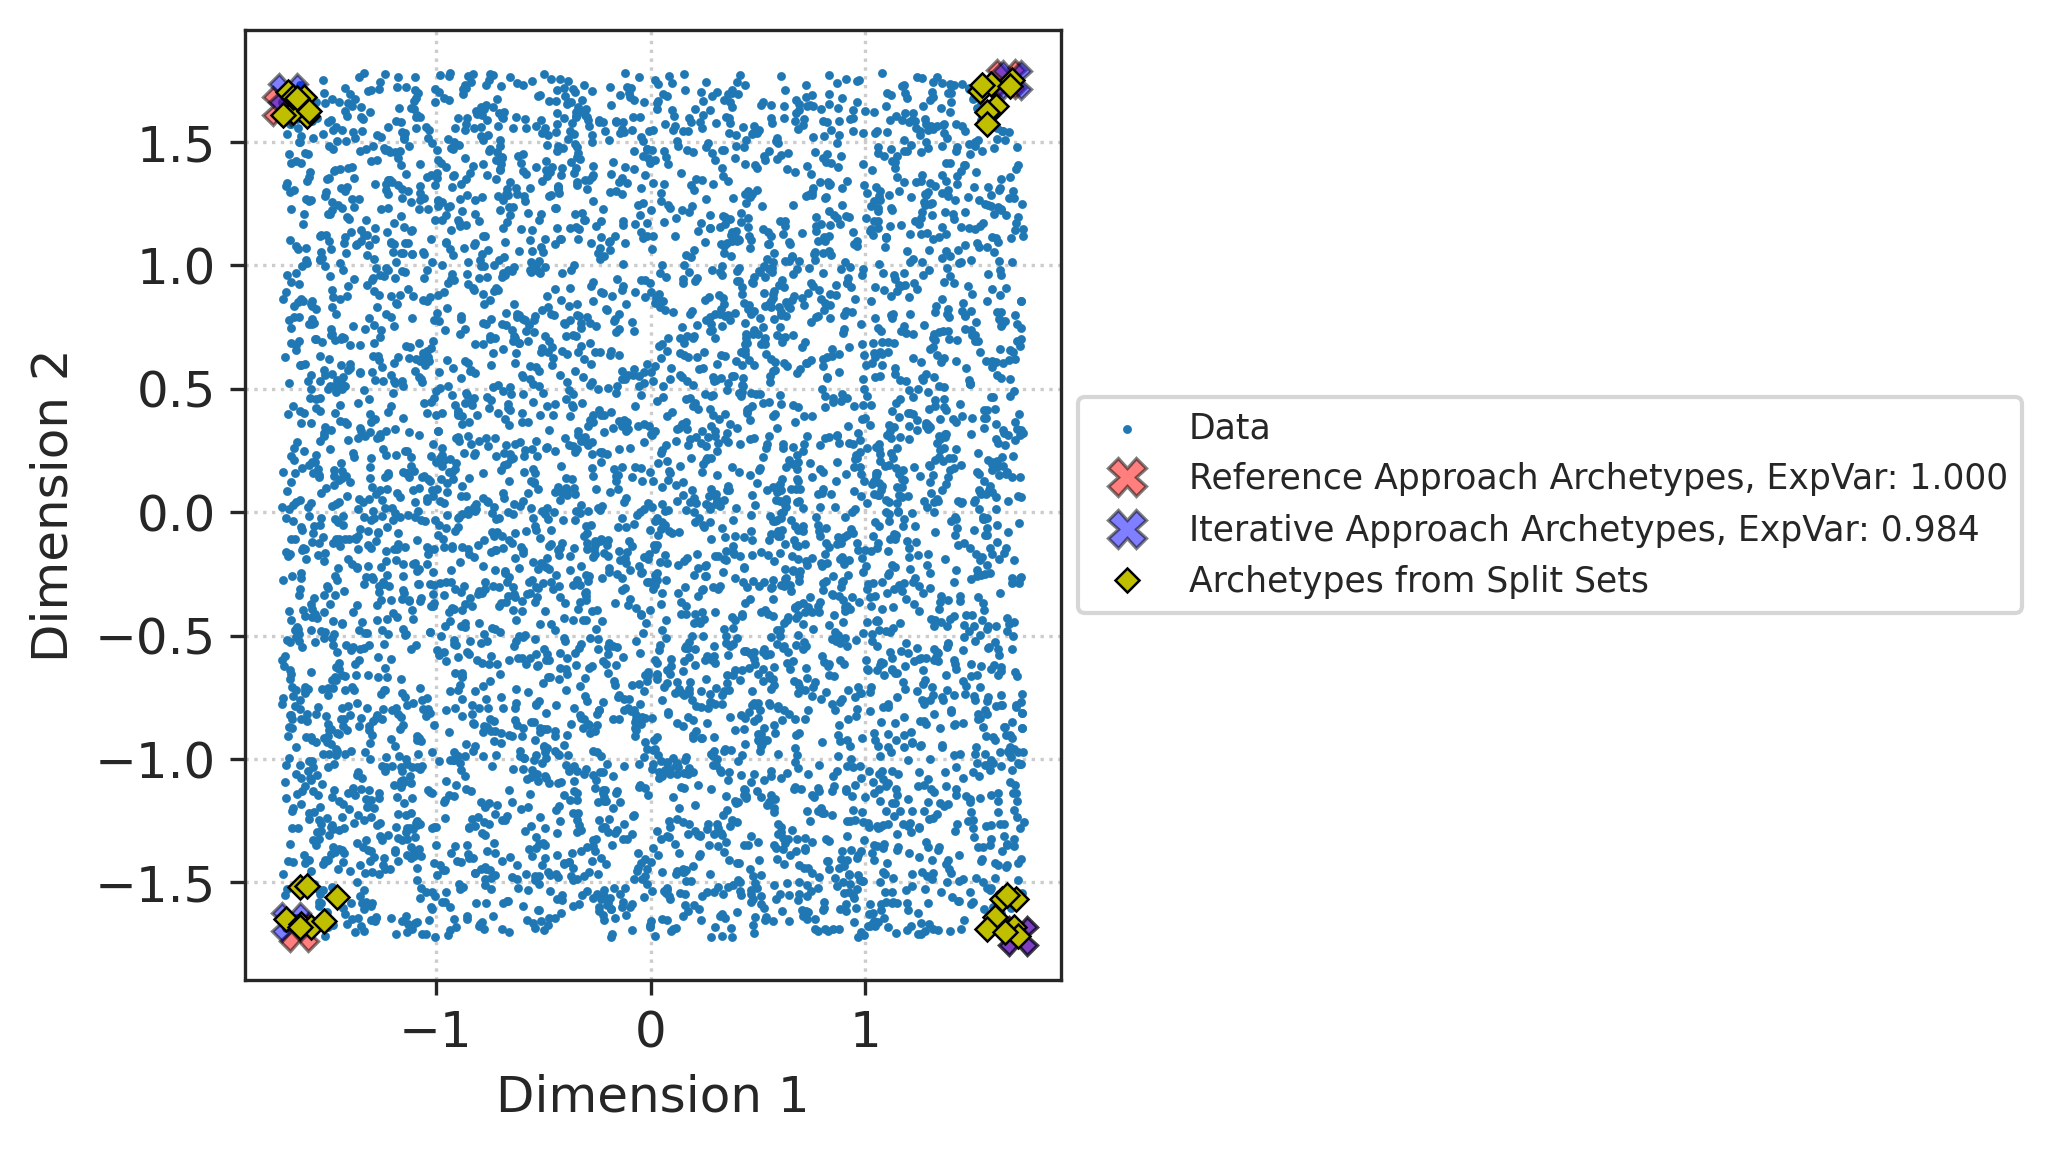

In [82]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{DATASET_TYPE}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 8 Subsets

In [80]:
numSubset = 8
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 8 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
  Subset 5
  Subset 6
  Subset 7
  Subset 8
Running archetypal analysis for all subsets...
119658600.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata1.pkl
119658601.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata2.pkl
119658602.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata3.pkl
119658603.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata4.pkl
119658604.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata5.pkl
119658605.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata6.pkl
119658606.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata7.pkl
119658607.gadi-pbs
  Submitted job for uniformSquarePIAA8Sdata8.pkl


In [83]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: uniformSquarePIAA8Soutput1.pkl
  Subset: uniformSquarePIAA8Soutput2.pkl
  Subset: uniformSquarePIAA8Soutput3.pkl
  Subset: uniformSquarePIAA8Soutput4.pkl
  Subset: uniformSquarePIAA8Soutput5.pkl
  Subset: uniformSquarePIAA8Soutput6.pkl
  Subset: uniformSquarePIAA8Soutput7.pkl
  Subset: uniformSquarePIAA8Soutput8.pkl
RSS FISTA = 0.139764
RSS FISTA = 0.071913965
RSS FISTA = 0.071725162
RSS AS = 0.040367951
RSS AS = 0.018009897
RSS AS = 0.010223281
RSS AS = 0.0064366133
RSS AS = 0.0044912146
RSS AS = 0.0034703879
RSS AS = 0.0029344114
RSS AS = 0.0026160873
RSS AS = 0.0024116077
RSS AS = 0.0022754258
RSS AS = 0.002181155
RSS AS = 0.0021126768
RSS AS = 0.0020624965
RSS AS = 0.0020256389
RSS AS = 0.0019985081
RSS AS = 0.0019784974
RSS AS = 0.001963711
RSS AS = 0.0019527666
RSS AS = 0.0019446533
RSS AS = 0.0019386304
RSS AS = 0.0019341535
RSS AS = 0.0019308219
RSS AS = 0.0019283399
RSS AS = 0.0019264892
RSS AS = 0.0019251079
RSS AS = 0.0019240762
RSS AS = 0.0019233127
RSS AS = 0.001

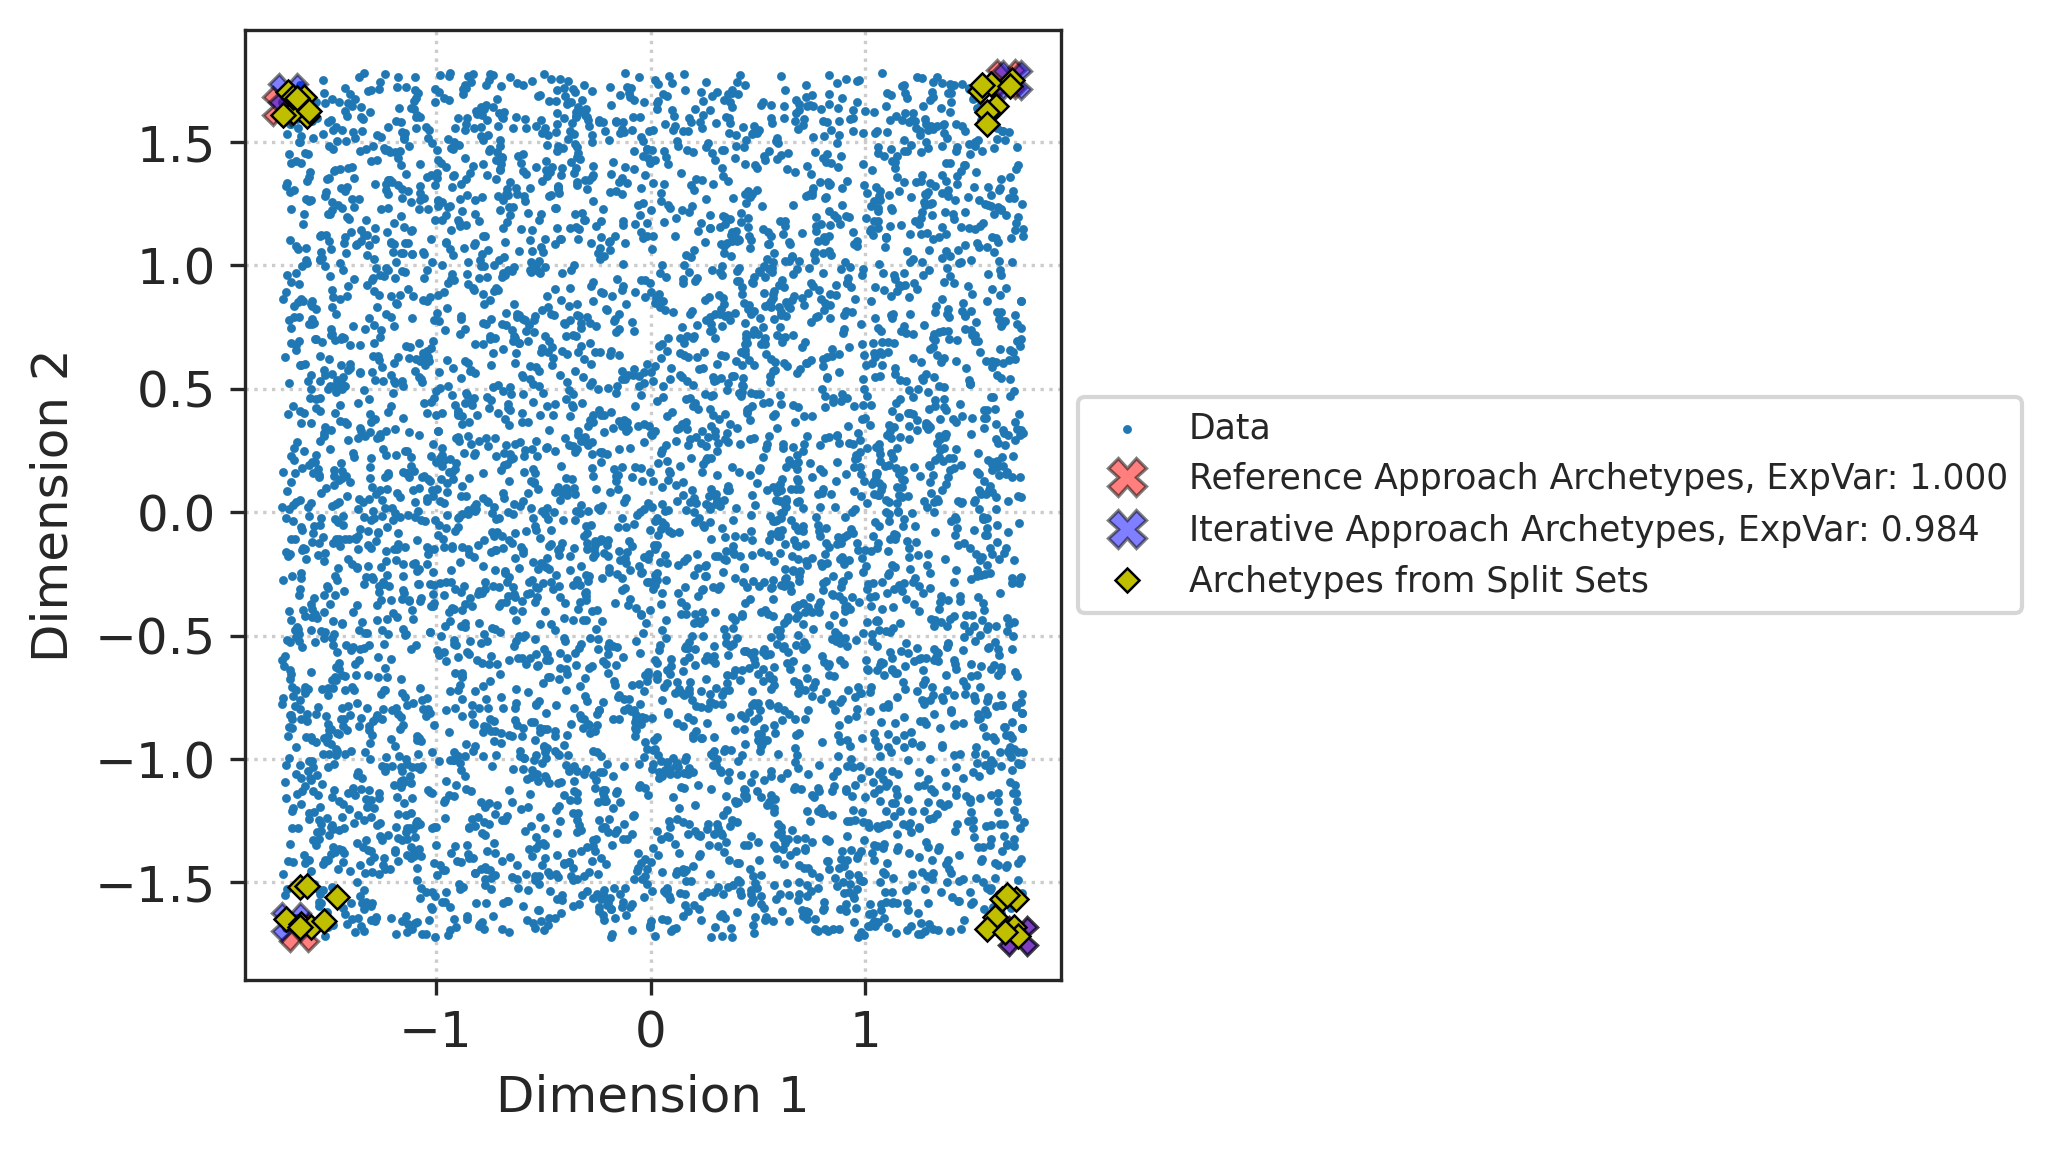

In [84]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{DATASET_TYPE}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

It could be seen that the final archetypes from both approaches lie very close to each other in the two-dimensional feature space, and the explained variances are both very high.

#### Visualising Most Archetypal Samples

Here we mark out the most archetypal samples in the data.

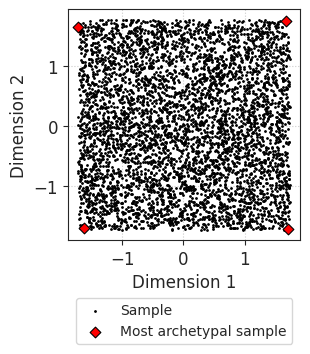

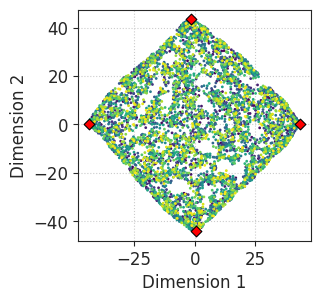

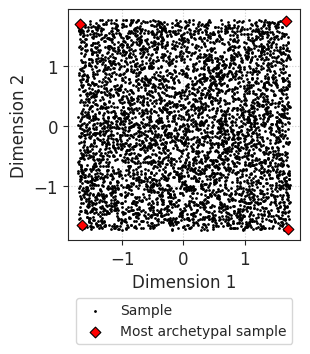

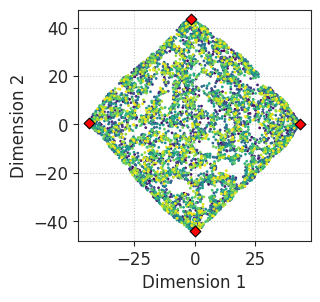

In [85]:
# Reference archetypal analysis
AAreference._extractCloseMatch()
closestSampleIdxsRAA = [sampleIdx for (sampleIdx, archetype) in AAreference.closeMatch.values()]
plotFirst2D(Xscaled, figName=f"{DATASET_TYPE}_rAA", markIdxs=closestSampleIdxsRAA)
plotTSNE(Xscaled, figNamePrefix=f"{DATASET_TYPE}_rAA", perplexity=100, markIdxs=closestSampleIdxsRAA)

# Iterative archetypal analysis
AAiterative._extractCloseMatch()
closestSampleIdxsIAA = [sampleIdx for (sampleIdx, archetype) in AAiterative.closeMatch.values()]
plotFirst2D(Xscaled, figName=f"{DATASET_TYPE}_iAA", markIdxs=closestSampleIdxsIAA)
plotTSNE(Xscaled, figNamePrefix=f"{DATASET_TYPE}_iAA", perplexity=100, markIdxs=closestSampleIdxsIAA)

### Blob

#### Load Data


KeyboardInterrupt



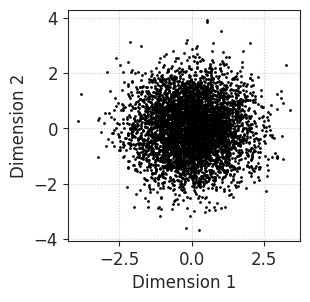

In [107]:
# Generate data
NUM_SAMPLES = 5000
DATASET_TYPE = 'blobPIAA'
X, y_true = make_blobs(n_samples=NUM_SAMPLES, centers=1, cluster_std=30, random_state=RANDOM_STATE)

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Visualise data 
plotFirst2D(Xscaled, figName=DATASET_TYPE)  # First two dimensions
plotTSNE(Xscaled, figNamePrefix=DATASET_TYPE, perplexity=100)  # Manifold learning

#### Extracting Archetypes

Here we extract the *8* archetypes from the dataset. For the iterative approach we also compare the results when we split the original dataset into *2*, *4*, and *8* subsets.

##### 2 Subsets

In [87]:
numArchetypes, numSubset = 8, 2

# Run the reference archetypal analysis for comparison with the parallel iterative approach
AAreference = runRAA(Xscaled, numArchetypes=numArchetypes, robust=ROBUST, onlyZ=False, randomState=RANDOM_STATE, verbose=VERBOSE)

RSS FISTA = 567.92373
RSS FISTA = 343.48076
RSS FISTA = 242.36549
RSS AS = 187.74863
RSS AS = 39.155246
RSS AS = 11.870053
RSS AS = 9.1949169
RSS AS = 7.4846296
RSS AS = 6.2927405
RSS AS = 5.4095055
RSS AS = 4.7313398
RSS AS = 4.2041135
RSS AS = 3.7895914
RSS AS = 3.4636306
RSS AS = 3.1919211
RSS AS = 2.9622379
RSS AS = 2.7680346
RSS AS = 2.6018724
RSS AS = 2.4542925
RSS AS = 2.3219878
RSS AS = 2.2069929
RSS AS = 2.1105205
RSS AS = 2.0218436
RSS AS = 1.9396526
RSS AS = 1.8627398
RSS AS = 1.7906067
RSS AS = 1.7230031
RSS AS = 1.6597606
RSS AS = 1.6159025
RSS AS = 1.5874906
RSS AS = 1.5602311
RSS AS = 1.5340612
RSS AS = 1.5088742
RSS AS = 1.4845962
RSS AS = 1.4611744
RSS AS = 1.4385664
RSS AS = 1.4166985
RSS AS = 1.3955377
RSS AS = 1.3750478
RSS AS = 1.3552505
RSS AS = 1.3360983
RSS AS = 1.3175517
RSS AS = 1.2995897
RSS AS = 1.282199
RSS AS = 1.2653483
RSS AS = 1.2490316
RSS AS = 1.2332042
RSS AS = 1.2178245
RSS AS = 1.2028893
RSS AS = 1.188373
RSS AS = 1.1742623
RSS AS = 1.160552
RSS AS

In [88]:
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 2 subsets...
  Subset 1
  Subset 2
Running archetypal analysis for all subsets...
119658732.gadi-pbs
  Submitted job for blob2Sdata1.pkl
119658733.gadi-pbs
  Submitted job for blob2Sdata2.pkl


In [90]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: blob2Soutput1.pkl
  Subset: blob2Soutput2.pkl
RSS FISTA = 2.100807
RSS FISTA = 1.8331286
RSS FISTA = 1.5590622
RSS AS = 1.1852474
RSS AS = 0.96169856
RSS AS = 0.77831096
RSS AS = 0.61875842
RSS AS = 0.48620344
RSS AS = 0.38216737
RSS AS = 0.30714623
RSS AS = 0.25753621
RSS AS = 0.22620565
RSS AS = 0.2062005
RSS AS = 0.1928696
RSS AS = 0.1836549
RSS AS = 0.17719273
RSS AS = 0.17267548
RSS AS = 0.1695537
RSS AS = 0.16742344
RSS AS = 0.16598432
RSS AS = 0.16501763
RSS AS = 0.16436869
RSS AS = 0.16392817
RSS AS = 0.16362259
RSS AS = 0.16340972
RSS AS = 0.16326028
RSS AS = 0.16315429
RSS AS = 0.16307826
RSS AS = 0.16302299
RSS AS = 0.16298233
RSS AS = 0.1629521
RSS AS = 0.16292941
RSS AS = 0.16291224
RSS AS = 0.16289917
RSS AS = 0.16288917
RSS AS = 0.16288148
RSS AS = 0.16287556
RSS AS = 0.16287099
RSS AS = 0.16286746
RSS AS = 0.16286472
RSS AS = 0.1628626
RSS AS = 0.16286095
RSS AS = 0.16285968
RSS AS = 0.16285869
RSS AS = 0.16285792
RSS AS = 0.16285732
RSS AS = 0.16285686
RSS AS

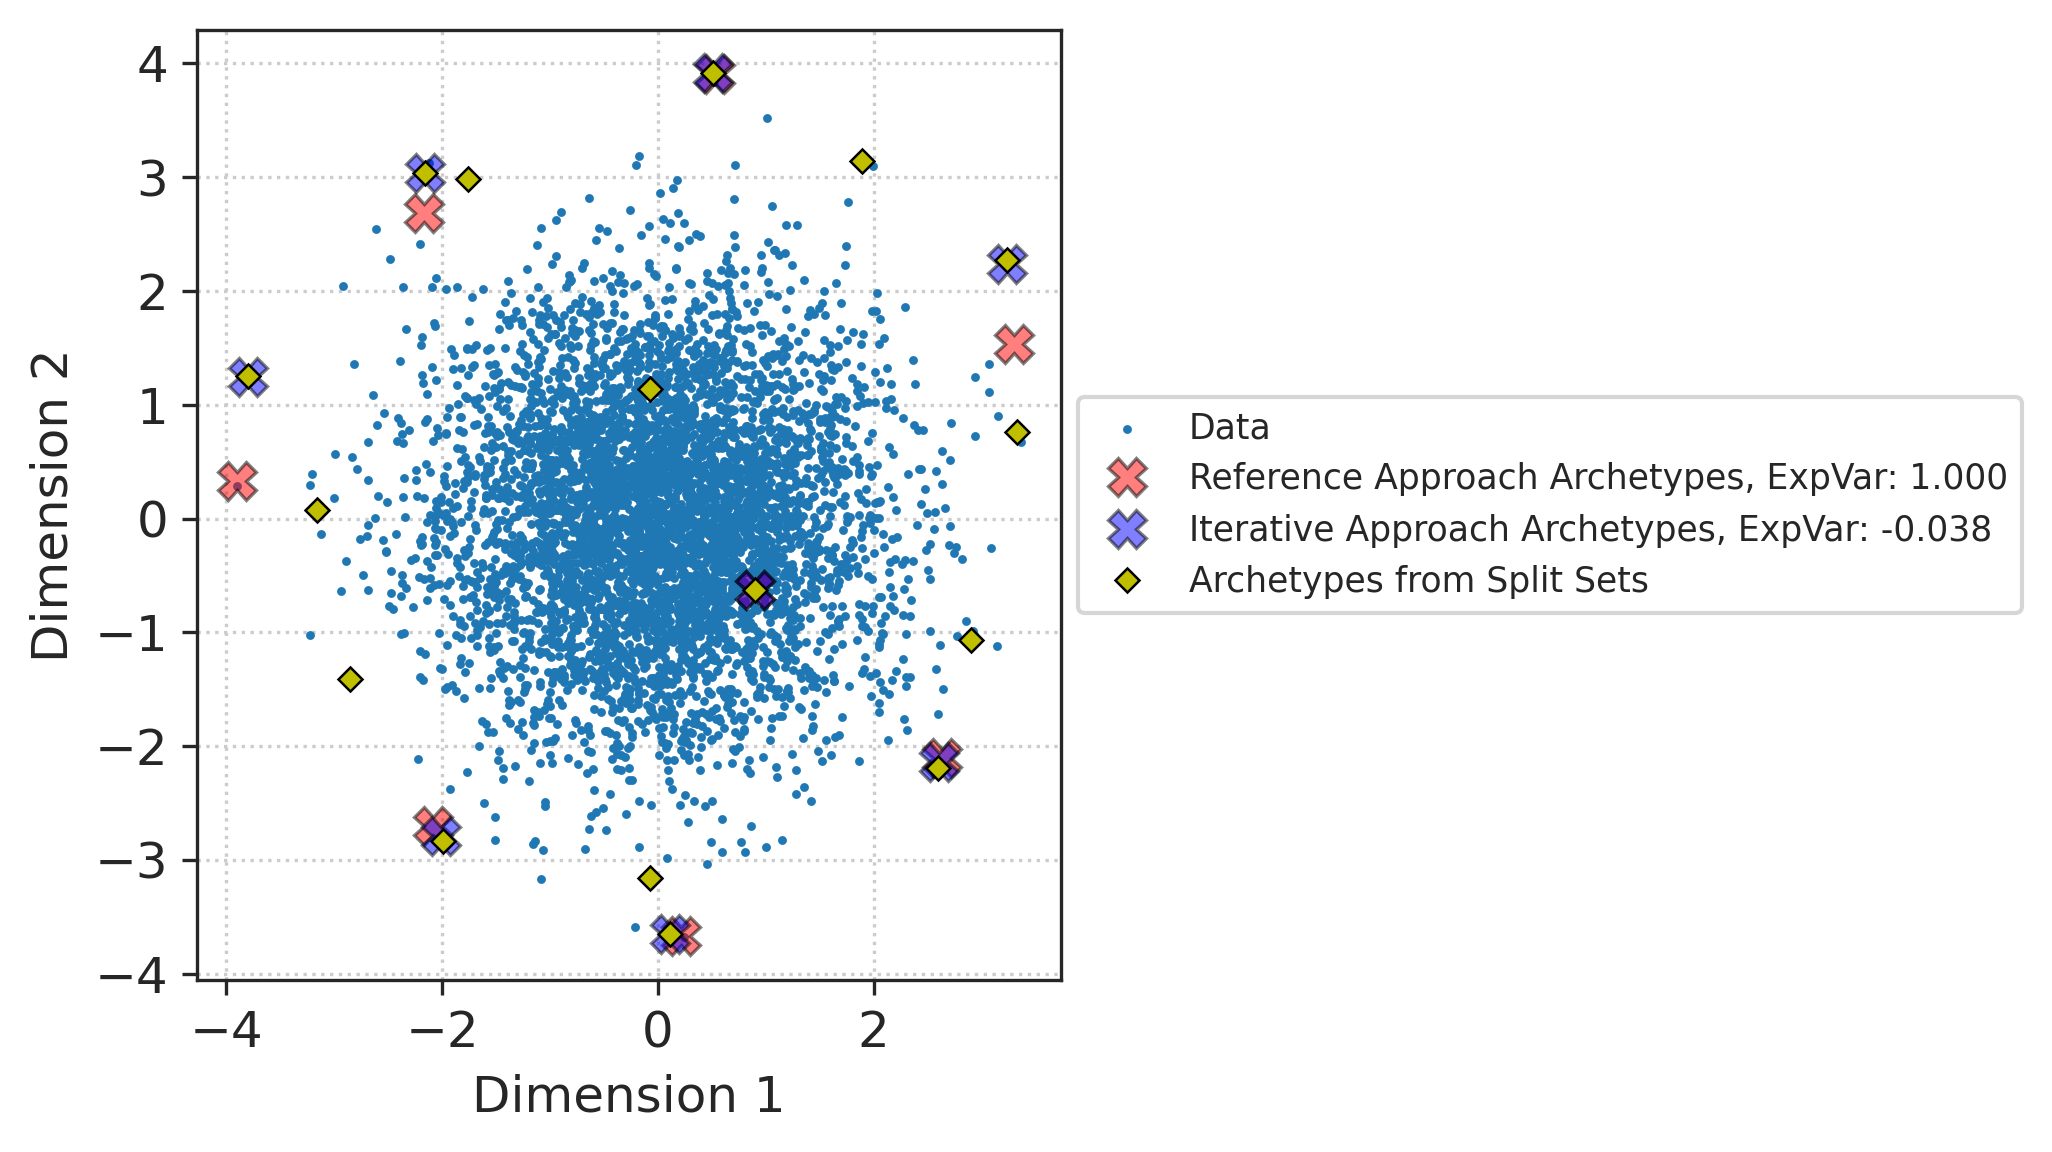

In [91]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{DATASET_TYPE}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 4 Subsets

In [103]:
numSubset = 4
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 4 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
Running archetypal analysis for all subsets...
119659903.gadi-pbs
  Submitted job for blob4Sdata1.pkl
119659904.gadi-pbs
  Submitted job for blob4Sdata2.pkl
119659905.gadi-pbs
  Submitted job for blob4Sdata3.pkl
119659906.gadi-pbs
  Submitted job for blob4Sdata4.pkl


In [104]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust
                       =ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: blob4Soutput1.pkl
  Subset: blob4Soutput2.pkl
  Subset: blob4Soutput3.pkl
  Subset: blob4Soutput4.pkl
RSS FISTA = 3.973773
RSS FISTA = 2.2883724
RSS FISTA = 1.9764651
RSS AS = 1.4588842
RSS AS = 1.3126855
RSS AS = 1.2699324
RSS AS = 1.2433379
RSS AS = 1.2272163
RSS AS = 1.2178539
RSS AS = 1.2131733
RSS AS = 1.2101261
RSS AS = 1.207911
RSS AS = 1.2061514
RSS AS = 1.2046438
RSS AS = 1.2032787
RSS AS = 1.2019961
RSS AS = 1.2007623
RSS AS = 1.1995578
RSS AS = 1.1983701
RSS AS = 1.1971921
RSS AS = 1.1960333
RSS AS = 1.1948753
RSS AS = 1.1937146
RSS AS = 1.1925489
RSS AS = 1.1913762
RSS AS = 1.1901944
RSS AS = 1.1890013
RSS AS = 1.1877947
RSS AS = 1.1865726
RSS AS = 1.185333
RSS AS = 1.1840737
RSS AS = 1.1827927
RSS AS = 1.181488
RSS AS = 1.1801574
RSS AS = 1.1787988
RSS AS = 1.1774255
RSS AS = 1.1760541
RSS AS = 1.1746824
RSS AS = 1.1733079
RSS AS = 1.1719283
RSS AS = 1.1705412
RSS AS = 1.1691444
RSS AS = 1.1677356
RSS AS = 1.1663126
RSS AS = 1.1648733
RSS AS = 1.1634155
RSS AS = 

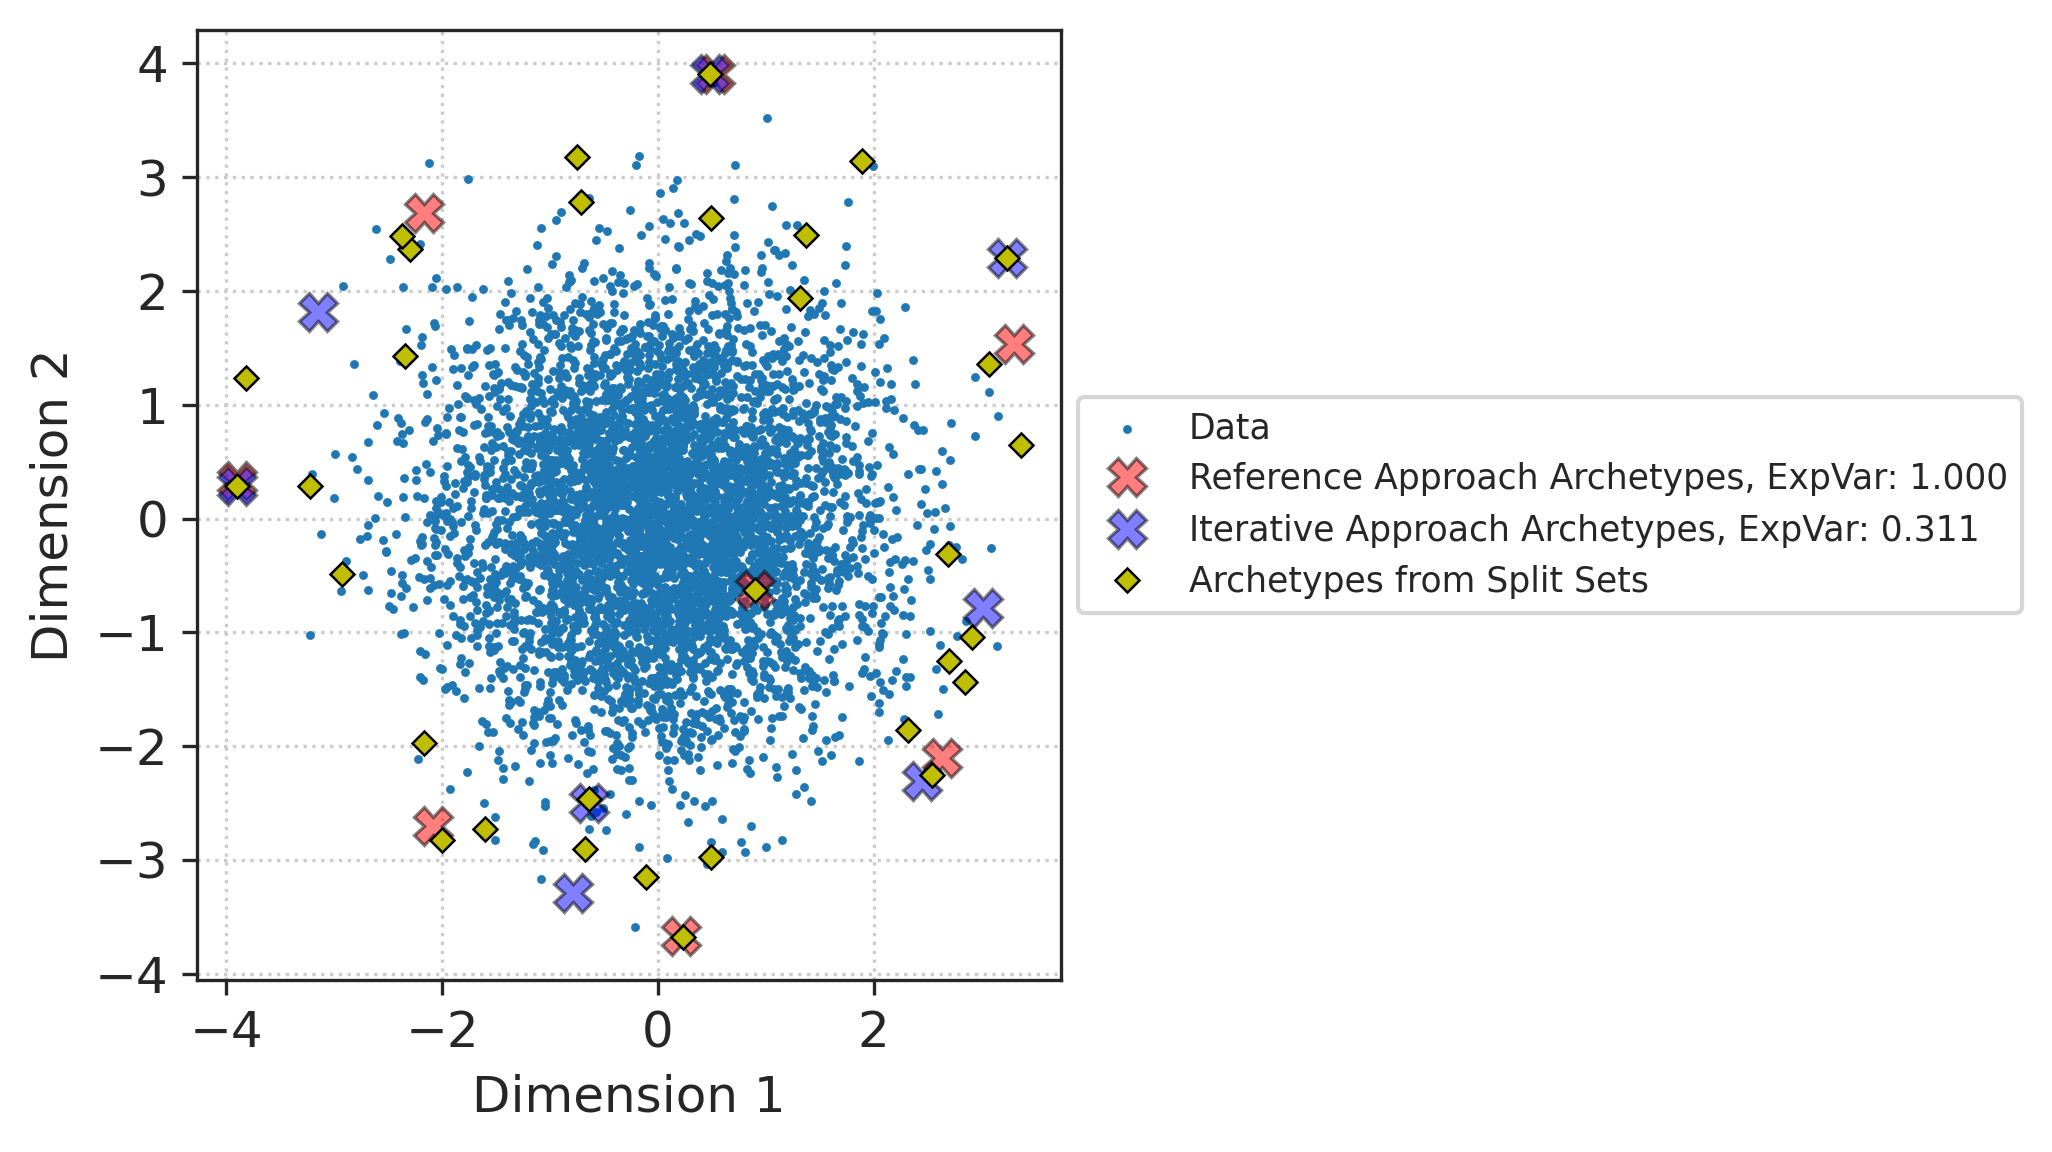

In [105]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{DATASET_TYPE}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 8 Subsets

In [95]:
numSubset = 8
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 8 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
  Subset 5
  Subset 6
  Subset 7
  Subset 8
Running archetypal analysis for all subsets...
119659330.gadi-pbs
  Submitted job for blob8Sdata1.pkl
119659333.gadi-pbs
  Submitted job for blob8Sdata2.pkl
119659337.gadi-pbs
  Submitted job for blob8Sdata3.pkl
119659340.gadi-pbs
  Submitted job for blob8Sdata4.pkl
119659343.gadi-pbs
  Submitted job for blob8Sdata5.pkl
119659346.gadi-pbs
  Submitted job for blob8Sdata6.pkl
119659349.gadi-pbs
  Submitted job for blob8Sdata7.pkl
119659352.gadi-pbs
  Submitted job for blob8Sdata8.pkl


In [97]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: blob8Soutput1.pkl
  Subset: blob8Soutput2.pkl
  Subset: blob8Soutput3.pkl
  Subset: blob8Soutput4.pkl
  Subset: blob8Soutput5.pkl
  Subset: blob8Soutput6.pkl
  Subset: blob8Soutput7.pkl
  Subset: blob8Soutput8.pkl
RSS FISTA = 5.8764293
RSS FISTA = 3.0170817
RSS FISTA = 2.2436112
RSS AS = 1.3450693
RSS AS = 0.79834001
RSS AS = 0.59771187
RSS AS = 0.47731556
RSS AS = 0.40787554
RSS AS = 0.3669569
RSS AS = 0.33937525
RSS AS = 0.32025217
RSS AS = 0.30611369
RSS AS = 0.29531282
RSS AS = 0.28677539
RSS AS = 0.28020008
RSS AS = 0.27453806
RSS AS = 0.2696049
RSS AS = 0.26554301
RSS AS = 0.26200497
RSS AS = 0.25876113
RSS AS = 0.25578854
RSS AS = 0.25306601
RSS AS = 0.25064174
RSS AS = 0.24847288
RSS AS = 0.24651894
RSS AS = 0.24476438
RSS AS = 0.24315415
RSS AS = 0.24167331
RSS AS = 0.2403122
RSS AS = 0.23906179
RSS AS = 0.23791367
RSS AS = 0.23686002
RSS AS = 0.23589354
RSS AS = 0.23500742
RSS AS = 0.23419538
RSS AS = 0.23345158
RSS AS = 0.23277271
RSS AS = 0.23215197
RSS AS = 0.231

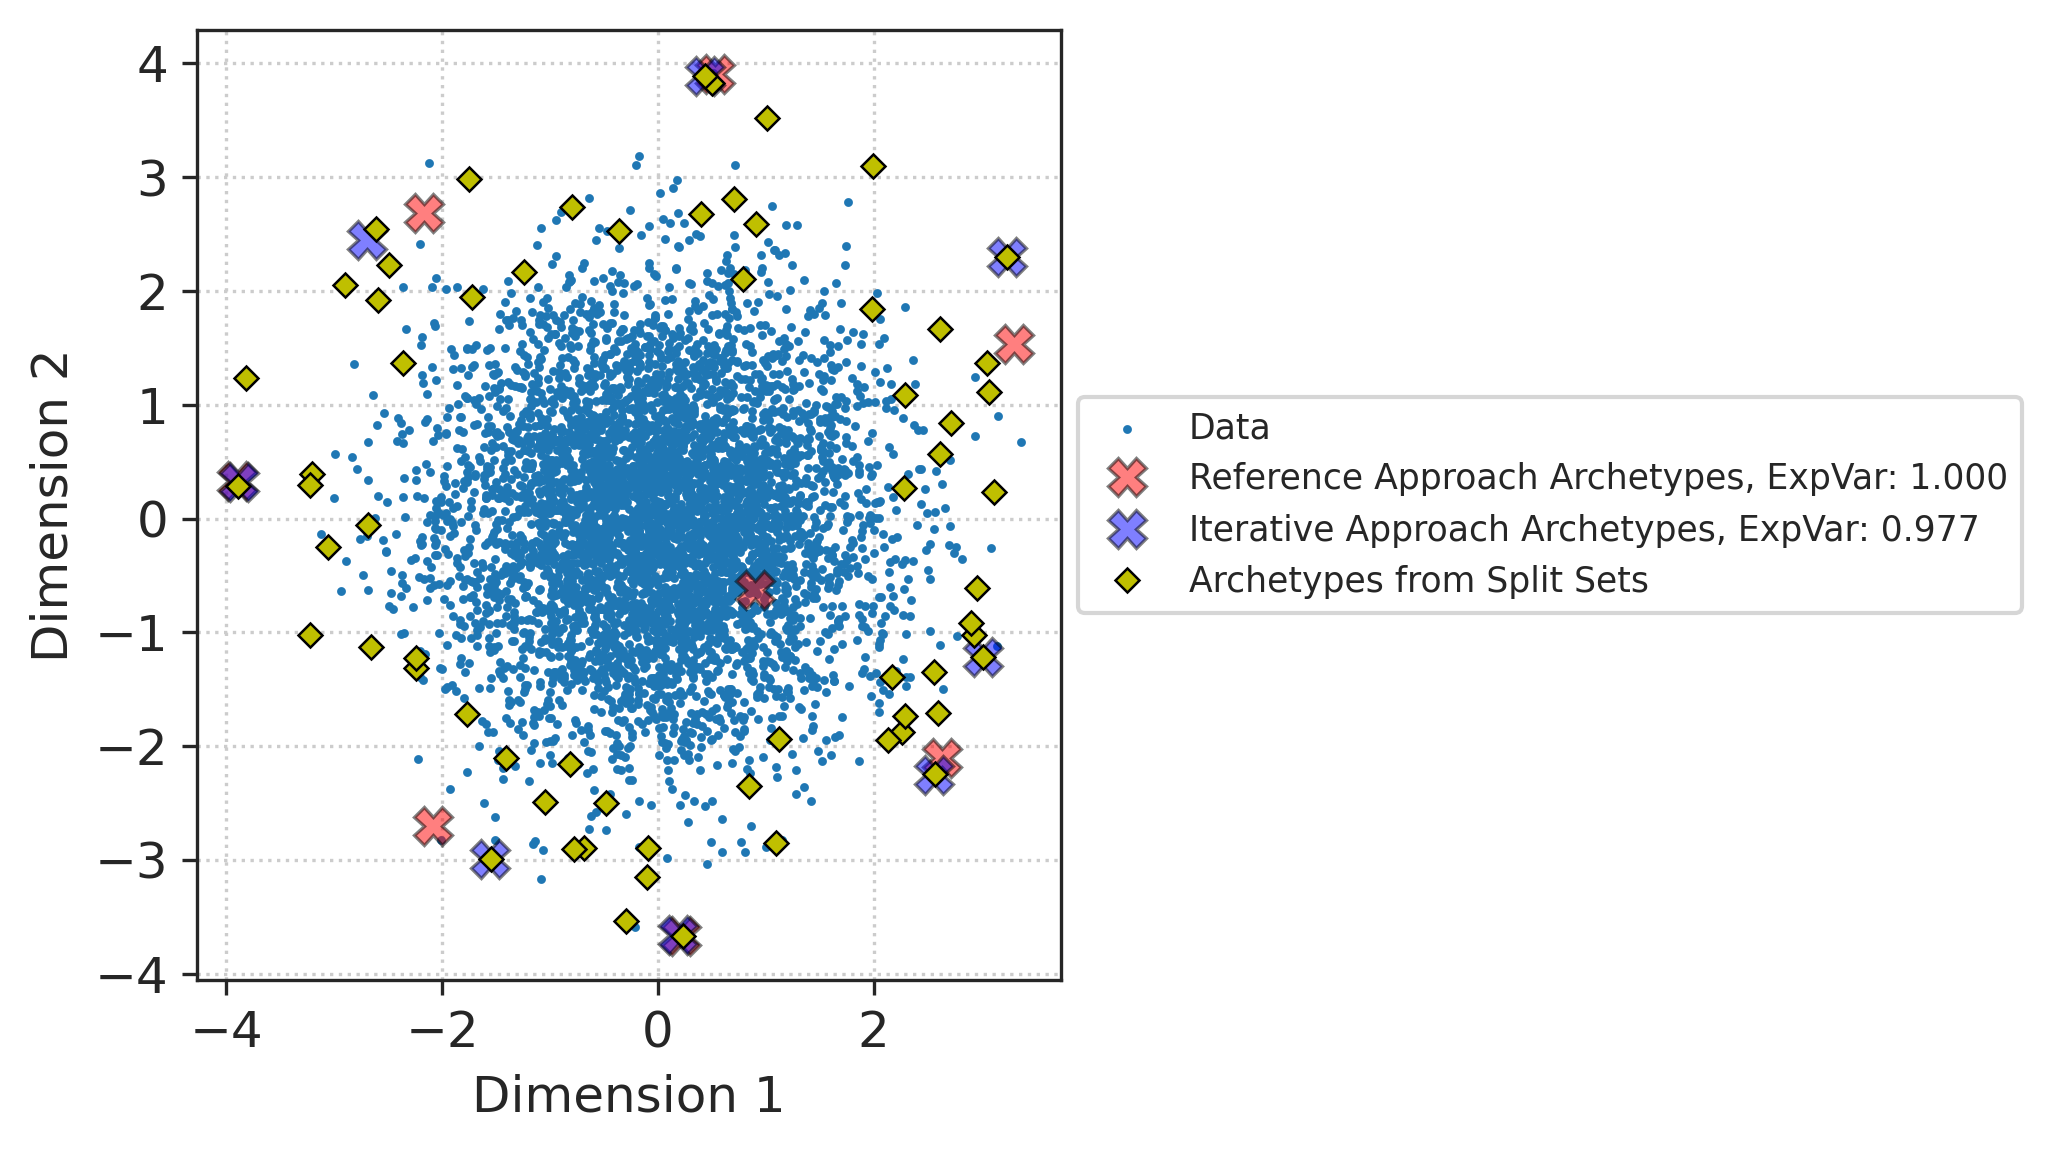

In [98]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{DATASET_TYPE}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

#### Visualising Most Archetypal Samples

Here we mark out the most archetypal samples in the data.

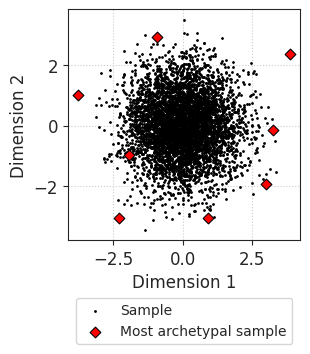

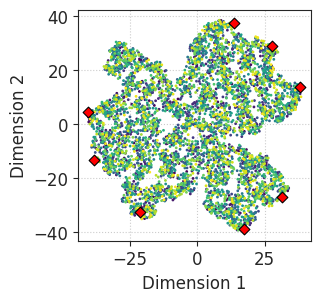

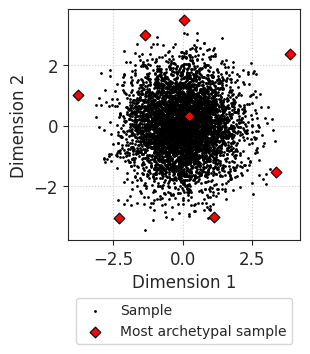

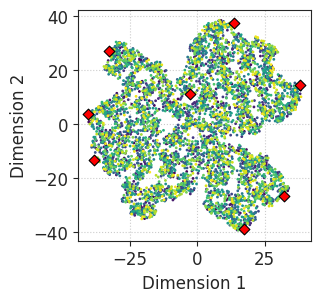

In [32]:
# Reference archetypal analysis
AAreference._extractCloseMatch()
closestSampleIdxsRAA = [sampleIdx for (sampleIdx, archetype) in AAreference.closeMatch.values()]
plotFirst2D(Xscaled, figName=f"{DATASET_TYPE}_rAA", markIdxs=closestSampleIdxsRAA)
plotTSNE(Xscaled, figNamePrefix=f"{DATASET_TYPE}_rAA", perplexity=100, markIdxs=closestSampleIdxsRAA)

# Iterative archetypal analysis
AAiterative._extractCloseMatch()
closestSampleIdxsIAA = [sampleIdx for (sampleIdx, archetype) in AAiterative.closeMatch.values()]
plotFirst2D(Xscaled, figName=f"{DATASET_TYPE}_iAA", markIdxs=closestSampleIdxsIAA)
plotTSNE(Xscaled, figNamePrefix=f"{DATASET_TYPE}_iAA", perplexity=100, markIdxs=closestSampleIdxsIAA)

While the locations of the final archetypes from both approaches do not overlap very much with each other in the two-dimensional feature space for this dataset, the explained variances are both very high.

## Functionalities Demonstration

From here onwards we will demonstrate the functionalities provided by *archetypes.py*.

The following functionalities are covered:
- extraction of the archetype attributes, 
- mapping of data to the archetype space,
- visualisation of archetype profiles (contributions of the archetypes in describing any other data sample), 
- identification of the most archetypal data samples, 
- visualisation of the data samples and archetypes on parallel axis.

### Load Data

The skeleton dataset will be used for the following demonstration to allow comparison with previous methods. 

The dataset:
- is a real world dataset used for demonstration in [From Spider-Man to Hero -- Archetypal Analysis in R](https://www.jstatsoft.org/article/view/v030i08). 
- was collected by Heinz G et al. in [Exploring Relationships in Body Dimensions](http://www.amstat.org/publications/jse/v11n2/datasets.heinz.html).
- includes 507 samples, of which 247 are men and 260 are women.
- has 25 features, but only 11 were used in [From Spider-Man to Hero -- Archetypal Analysis in R](https://www.jstatsoft.org/article/view/v030i08).

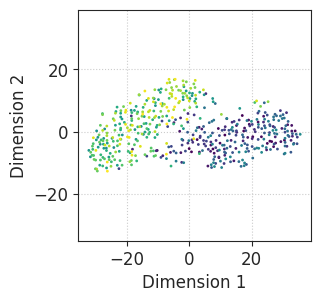

In [10]:
# Load the data
r = requests.get('http://jse.amstat.org/datasets/body.dat.txt')
data = np.array(list(map(lambda x: list(map(float, x.split())), r.text.splitlines())))
DATASET_TYPE = 'skeletonPIAA'

# Order the columns in the similar order that appears in previous studies.
columns = ['AnkleDiam', 'KneeDiam', 'WristDiam', 'Bitro', 'Biil', 'ElbowDiam', 'ChestDiam', 'ChestDp', 'Biac', 'Height', 'Gender']
selectedCols = [8, 7, 6, 2, 1, 5, 4, 3, 0, 23, 24]
df = pd.DataFrame(data[:, selectedCols], columns=columns)

# Map the entries in the gender column into strings
gender = {1.0: 'male', 0.0: 'female'}
df['Gender'] = df.apply(lambda row: gender[row['Gender']], axis = 1)

# Generate the feature set
featNames = ['AnkleDiam', 'KneeDiam', 'WristDiam', 'Bitro', 'Biil', 'ElbowDiam', 'ChestDiam', 'ChestDp', 'Biac', 'Height']
X = df[featNames].values

# Standardise all features
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Data visualisation
plotTSNE(Xscaled, figNamePrefix='skeleton', perplexity=30)

### Extracting Attributes from Archetypal Analysis Object

Once the **ArchetypalAnalysis()** object was fitted to the data, we can extract a few outputs from it. 

Below is a list of the attributes that could be extracted. Note that $n$, $m$, and $k$ refers to the number of samples, number of features, and number of archetypes, respectively:
- **.archetypes** returns $Z$ (with a shape of $(m \times k)$), the computed archetypes.
- **.alfa** returns $A$ (with a shape of $(k \times n)$), the coefficient matrix to multiply to $Z$ to approximately reconstruct $X$.
- **.beta** returns $B$ (with a shape of $(n \times k)$), the coefficient matrix to multiply to $X$ to obtain $Z$.
- **.X** returns $X^T$ (with a shape of $(m \times n)$), the transposed original data.
- **.X_approx** returns $X_{\text{approx}}$ (with a shape of $(m \times n)$), the reconstructed data.
- **.explainedVariance_** tells how close is $X_{\text{approx}}$ to $X$. It is computed using *explained_variance_score()* from the *sklearn* package.
- **.archetype_profile** provides the profile of the archetypes (with a shape of $(m \times n)$). It shows the fraction of importance of each feature for each archetype (which sums to 1.0).
- **.closeMatch** contains the most archetypal data points. It is only computed after **._extractCloseMatch()** is run.
- **.runTime** returns the execution duration (s) of the algorithm for $Z$ to be computed.

The following outputs are only useful when *iterative* is set to *True*:
- **.subsets_sample_idxs** returns the indices of the samples for each data subset.
- **.subsets_Zs** returns the archetypes obtained from each data subset.

In [18]:
numArchetypes, numSubset = 10, 2
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 2 subsets...
  Subset 1
  Subset 2
Running archetypal analysis for all subsets...
119661204.gadi-pbs
  Submitted job for skeletonPIAA2Sdata1.pkl
119661205.gadi-pbs
  Submitted job for skeletonPIAA2Sdata2.pkl


In [42]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AA = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
              robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
              datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: skeletonPIAA2Soutput1.pkl
  Subset: skeletonPIAA2Soutput2.pkl
RSS FISTA = 36.446591
RSS FISTA = 35.580854
RSS FISTA = 34.985417
RSS AS = 33.715876
RSS AS = 32.397845
RSS AS = 31.658739
RSS AS = 31.379324
RSS AS = 31.317626
RSS AS = 31.29951
RSS AS = 31.287073
RSS AS = 31.276157
RSS AS = 31.266273
RSS AS = 31.25717
RSS AS = 31.248486
RSS AS = 31.239305
RSS AS = 31.23186
RSS AS = 31.226027
RSS AS = 31.22136
RSS AS = 31.217597
RSS AS = 31.214546
RSS AS = 31.212066
RSS AS = 31.210044
RSS AS = 31.208394
RSS AS = 31.207046
RSS AS = 31.205943
RSS AS = 31.205041
RSS AS = 31.204302
RSS AS = 31.203694
RSS AS = 31.203196
RSS AS = 31.202788
RSS AS = 31.202453
RSS AS = 31.202178
RSS AS = 31.201953
RSS AS = 31.201769
RSS AS = 31.201618
RSS AS = 31.201497
RSS AS = 31.201398
RSS AS = 31.201318
RSS AS = 31.201253
RSS AS = 31.2012
RSS AS = 31.201157
RSS AS = 31.201123
RSS AS = 31.201094
RSS AS = 31.201071
RSS AS = 31.201053
RSS AS = 31.201038
RSS AS = 31.201026
RSS AS = 31.201017
RSS AS = 31.2

In [43]:
print(f"Z:\n{AA.archetypes}\n")
print(f"A:\n{AA.alfa}\n")
print(f"B:\n{AA.beta}\n")
print(f"X:\n{AA.X}\n")
print(f"Approximately reconstructed X:\n{AA.Xapprox}\n")
print(f"Explained variance:\n{AA.explainedVariance_:.6f}\n")
print(f"Archetype profiles:\n{AA.archetypeProfile}\n")
print(f"Execution time (s):\n{AA.runTime:.6f}\n")
AA._extractCloseMatch()
print(f"Most archetypal data samples:\n")
for (archNum, (archID, archFeats)) in AA.closeMatch.items():
    print(f"  Archetype {archNum}:    ID = {archID},    feats = {archFeats}")
print(f"Subset sample IDs:\n{AA.subsetsSampleIdxs}\n")
print(f"Subset archetypes:\n{AA.subsetsZs}\n")

Z:
[[-1.81373673e+00  2.33253870e+00  4.67862062e-01  2.57260154e+00
   8.34833843e-03  1.16177085e+00 -1.31939049e+00  6.46751539e-01
  -1.38039633e-03 -1.12939096e-01]
 [-1.92653645e+00  1.62173079e+00 -3.53184629e-01  1.31156620e+00
   3.31802788e+00  1.76458341e+00 -1.69040211e+00  3.44977640e-02
   1.48311560e-01  1.22060091e+00]
 [-2.17349899e+00  3.14042362e-01  1.54350717e+00  1.53322242e+00
   2.32443573e+00  1.09656016e+00 -7.64578013e-01  1.28167800e-01
  -6.53182262e-01 -1.35502852e-01]
 [-1.82423332e+00  2.72699245e+00  1.28987940e+00  5.39244969e-01
   1.57060104e+00  3.28300188e-01 -1.99230678e+00 -1.82133039e+00
  -4.68377963e-01  2.57256431e+00]
 [-9.63567310e-01  1.93895991e+00  1.57530439e+00  1.22704228e+00
   1.23942139e+00  1.18696025e-01 -3.99967367e+00 -9.99833814e-02
  -7.12125466e-01  2.02513215e+00]
 [-2.20738044e+00  1.90041953e+00  1.65632621e+00  1.24318352e+00
   1.35735916e+00  1.07087112e+00 -1.14674028e+00  9.89328601e-02
  -3.29151575e-01  4.32559093e

### Selecting the Appropriate Number of Archetypes

Here we use the elbow criterion to figure out the most appropriate choice of number of archetypes, $k$.

In [13]:
numSubset = 3
allNumArchetypes = range(2, 10)
for numArchetypes in allNumArchetypes:
    # Split the data into subsets and run archetypal analysis on each subset
    splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                            datasetType=f"{DATASET_TYPE}{numSubset}S{numArchetypes}A", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119662601.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata1.pkl
119662602.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata2.pkl
119662603.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119662605.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata1.pkl
119662606.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata2.pkl
119662608.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119662611.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata1.pkl
119662613.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata2.pkl
119662615.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running ar

  Subset: skeletonPIAA3Soutput1.pkl
  Subset: skeletonPIAA3Soutput2.pkl
  Subset: skeletonPIAA3Soutput3.pkl
RSS FISTA = 37.598167
RSS FISTA = 37.073953
RSS FISTA = 37.066754
RSS AS = 36.985436
RSS AS = 36.981154
RSS AS = 36.980997
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 36.980992
RSS AS = 

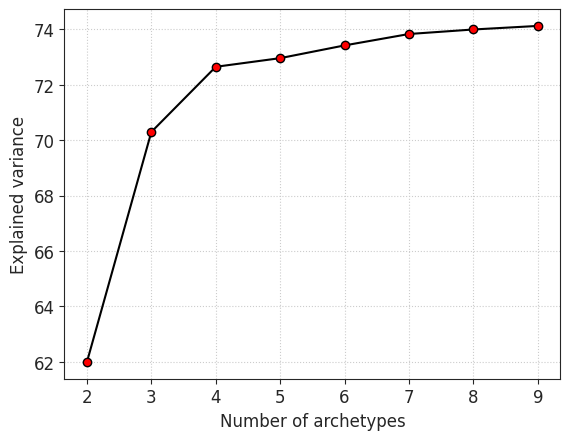

In [14]:
expVars = []
for numArchetypes in allNumArchetypes:
    # Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
    AA = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                  robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                  datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)
    expVars.append(AA.explainedVariance_)
plt.plot(allNumArchetypes, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance')
plt.grid(linestyle='dotted')

As the elbow occurs when **3** archetypes are used, we refit the data with this value. This also allows comparisons with the previous results from [Benyamin Motevalli](https://researchdata.edu.au/archetypal-analysis-package/1424520) and [Manuel J. A. Eugster](https://www.jstatsoft.org/article/view/v030i08).

In [11]:
numArchetypes, numSubset = 3, 3
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{DATASET_TYPE}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119676289.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata1.pkl
119676290.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata2.pkl
119676291.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata3.pkl
119676292.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata1.pkl
119676293.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata2.pkl
119676294.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata3.pkl
119676295.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata1.pkl
119676296.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata2.pkl
119676298.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata3.pkl
119676299.gadi-pbs
  Submitted job for skeletonPIAA3S5Adata1.pkl
119676300.gadi-pbs
  Submitted job for skeletonPIAA3S5Adata2.pkl
119676301.gadi-pbs
  Submitted job for skeletonPIAA3S5Adata3.pkl
119676302.gadi-pbs
  Submitted job for skeletonPIAA3S6Adata1.pkl
119676303.gadi-pbs
  Submitted job for ske

In [21]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AA = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
              robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
              datasetType=f"{DATASET_TYPE}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: skeletonPIAA3Soutput1.pkl
  Subset: skeletonPIAA3Soutput2.pkl
  Subset: skeletonPIAA3Soutput3.pkl
RSS FISTA = 169.82203
RSS FISTA = 147.8388
RSS FISTA = 144.96946
RSS AS = 143.70109
RSS AS = 143.45762
RSS AS = 143.39786
RSS AS = 143.37886
RSS AS = 143.3713
RSS AS = 143.36802
RSS AS = 143.36649
RSS AS = 143.36572
RSS AS = 143.36532
RSS AS = 143.36508
RSS AS = 143.36495
RSS AS = 143.36486
RSS AS = 143.36481
RSS AS = 143.36478
RSS AS = 143.36476
RSS AS = 143.36474
RSS AS = 143.36473
RSS AS = 143.36473
RSS AS = 143.36473
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 14

### Mapping Data to Archetype Space

We can map the data samples to the convex hull formed by the archetypes using simplex plots.

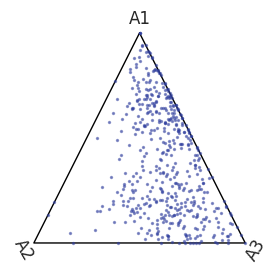

In [22]:
archIDs = list(range(AA.nArchetypes))
AA.plotSimplex(AA.alfa, archIDs, figNamePrefix=DATASET_TYPE)

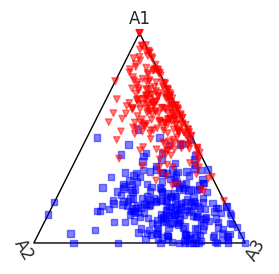

In [26]:
# Users have the flexibility to assign attributes (marker color, marker shape, marker size) to the data samples to enrich the plot.
dfArgs = df[['Gender']].copy()
dfArgs.loc[:, 'color'] = 'red'
dfArgs.loc[dfArgs['Gender']=='female', 'color'] = 'blue'

dfArgs.loc[:, 'marker'] = 'v'
dfArgs.loc[dfArgs['Gender']=='female', 'marker'] = 's'

dfArgs.loc[:, 'size'] = df[['Height']] / 10

plotArgs = {'color': dfArgs['color'], 's': dfArgs['size'], 'marker': dfArgs['marker']}

AA.plotSimplex(AA.alfa, archIDs, plotArgs, figNamePrefix=DATASET_TYPE)

Additional utility functions are included to allow more flexibities to create simplex plots and color the data points in different fashions. This requires three steps:
1. Create the simplex plot frame with **create_simplex_ax** utility function.
2. Map the **.alfa** values to the simplex frame using the **map_alfa_to_simplex** utility function.
3. Use standard matplotlib scatter plot to visualise data points.

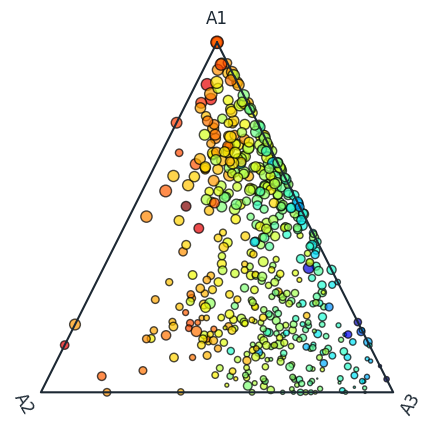

In [28]:
# STEP 1: Create the simplex plot. Users can control the color of gridlines and borders (edges) of the simplex plots. 
createSimplexAx(AA, gridOn=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', figSize=(5, 5))
# STEP 2: Map the alfa values to simplex plot.
mappedAlfa = mapAlfaToSimplex(AA.alfa, AA)
# STEP 3: Use scatter plots to add the mapped alfa to simplex frame.
# The data points are colored by 'Biil' attribute, while sizes are correlated to normalised 'ChestDiam'.
df['ChestDiamNorm'] = (df['ChestDiam'] - df['ChestDiam'].min()) / (df['ChestDiam'].max() - df['ChestDiam'].min())
plt.scatter(mappedAlfa[:,0], mappedAlfa[:,1], 
            c=df['Biil'], cmap='jet', edgecolor='k', 
            s=df['ChestDiamNorm'] * 80, alpha=0.7);

Any other point (e.g. prototypes of clusters) can also be mapped to the simplex plot to compare their relative locations (with other points provided or the overall dataset).

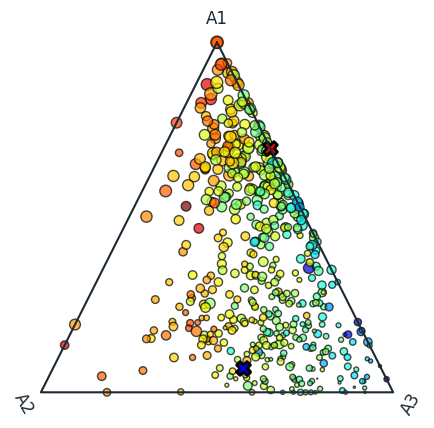

In [30]:
# STEP 1: Get the alpha values for males and females.
XavgMale = Xscaled[df['Gender'] == 'male'].mean(axis=0).reshape(1, -1)
XavgFemale = Xscaled[df['Gender'] == 'female'].mean(axis=0).reshape(1, -1)
_, alfaMale = AA.transform(XavgMale)
_, alfaFemale = AA.transform(XavgFemale)

# STEP 2: Create the simplex plot.
createSimplexAx(AA, gridOn=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', figSize=(5, 5))

# STEP 3: Map the alphas values to the plot.
mappedAlfa = mapAlfaToSimplex(AA.alfa, AA)
mappedAlfaMale = mapAlfaToSimplex(alfaMale, AA)
mappedAlfaFemale = mapAlfaToSimplex(alfaFemale, AA)

# STEP 4: Plot the data samples.
df['ChestDiamNorm'] = (df['ChestDiam']-df['ChestDiam'].min()) / (df['ChestDiam'].max()-df['ChestDiam'].min())
plt.scatter(mappedAlfa[:, 0], mappedAlfa[:, 1], c=df['Biil'], cmap='jet', edgecolor='k', s=df['ChestDiamNorm'] * 80, alpha=0.7);
plt.scatter(mappedAlfaMale[:, 0], mappedAlfaMale[:, 1], marker='X', s=100, color='r', edgecolor='k', linewidth=2);
plt.scatter(mappedAlfaFemale[:, 0], mappedAlfaFemale[:, 1], marker='X', s=100, color='b', edgecolor='k', linewidth=2);

### Visualising Archetype Profiles

The profile of the archetypes can be plot as bar plots or radar plots.

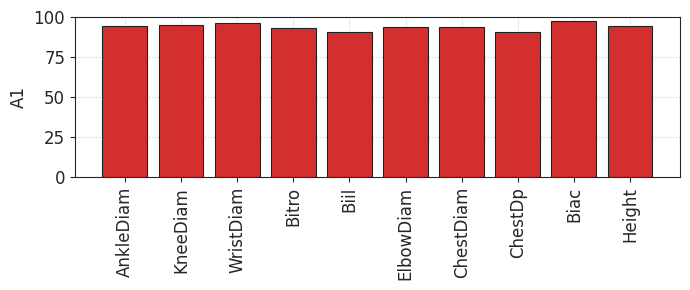

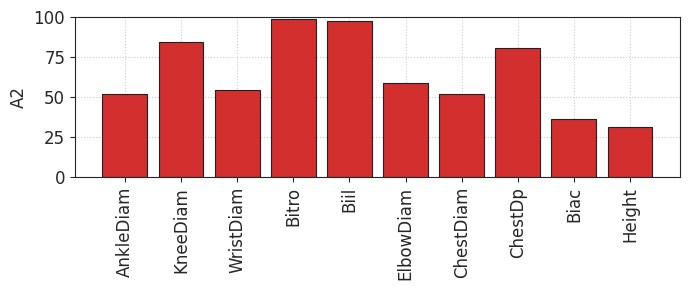

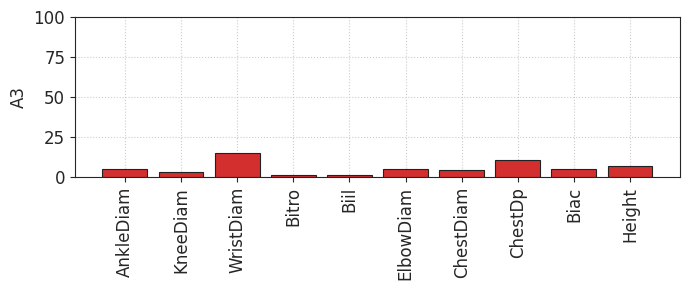

In [32]:
selectedFeatsIdxs = range(len(featNames))
AA.plotProfile(featNames, selectedFeatsIdxs, archIDs, figSize=(7, 3), figNamePrefix=DATASET_TYPE)

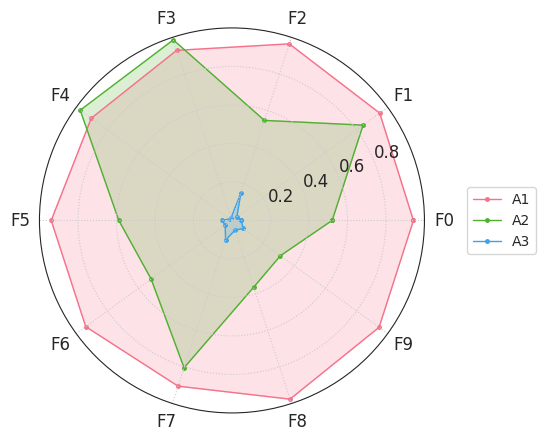

In [35]:
AA.plotRadarProfile(featNames, selectedFeatsIdxs, archIDs, sepArchs=False, showLabel=True, figSize=(5, 5), figNamePrefix=DATASET_TYPE)

### Identifying Most Archetypal Data Samples

The most archetypal data samples could be identified by running **._extractCloseMatch()** on the **ArchetypalAnalysis()** object.

Regarding the **.closeMatch** object:
- The keys are the archetypes.
- The first item in the tuple gives the index of the most archetypal data sample.
- The second item is the corresponding $\alpha$ array of that data point.

The data samples can be mapped to a simplex plot or displayed on a radar plot.

In [36]:
AA._extractCloseMatch()
AA.closeMatch

{1: (6, array([0.88570774, 0.        , 0.11429226])),
 2: (401, array([0.29709135, 0.39914049, 0.30376816])),
 3: (300, array([0.04424804, 0.05221486, 0.9035371 ]))}

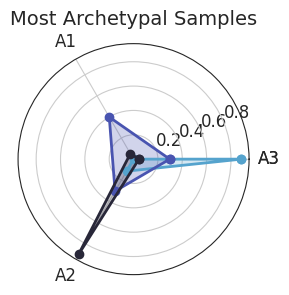

In [37]:
# Radar plot of the most archetypal data samples in the archetype space
AA.plotCloseMatch(title='Most Archetypal Samples')

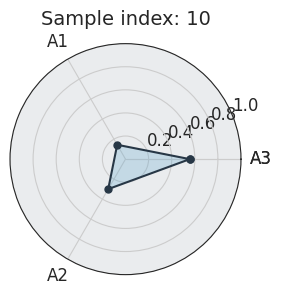

In [38]:
# Any data sample in the archetype space can also be plotted
idx = 10
plotRadarDatapoint(AA, Xscaled[idx, :].reshape(1,-1), title=f"Sample index: {idx}");

### Visualing Most Archetypal Samples on 2D Embedding Space from Manifold Learning

The most archetypal data samples can also be marked out on the 2D embedding space obtained from manifold learning (*t*-SNE in our case).

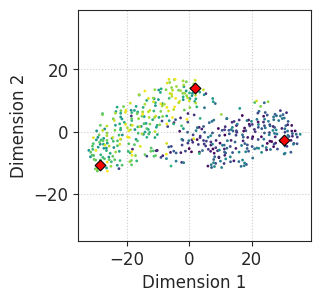

In [39]:
closestSampleIdxs = [sampleIdx for (sampleIdx, archetype) in AA.closeMatch.values()]
plotTSNE(Xscaled, figNamePrefix=DATASET_TYPE, markIdxs=closestSampleIdxs)

### Visualing Samples and Archetypes on Parallel Axis

The data samples and archetypes could also be plotted on a parallel axis.

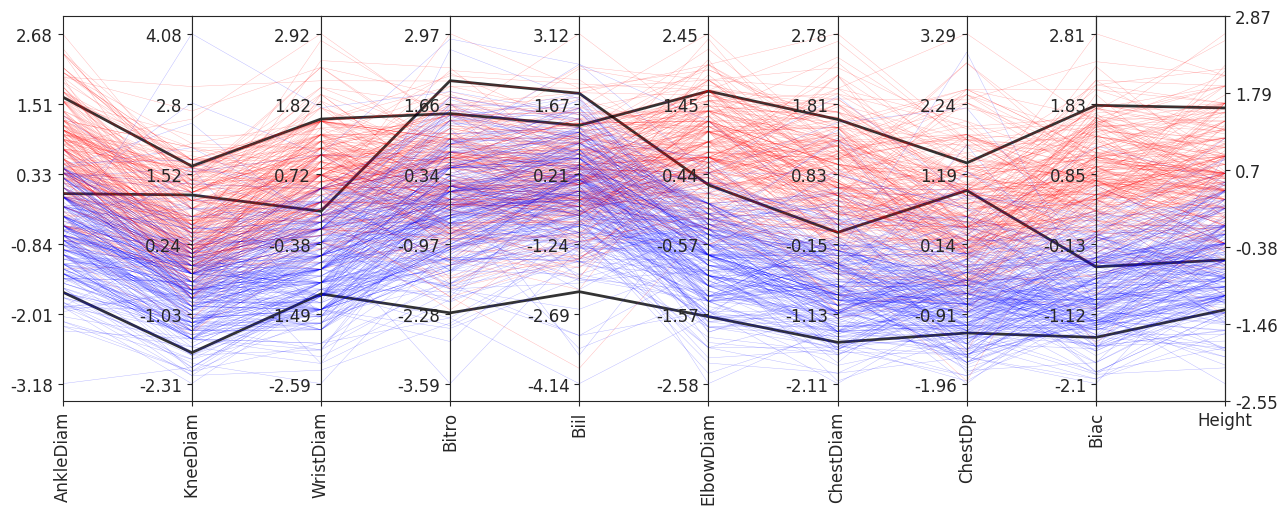

In [40]:
AA.parallelPlot(featNames, dfArgs[['color']].copy(), linewidth='0.3', arch_color='k')